In [4]:
import Tiled_Classification_RF as TCRF
import os, tempfile
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from sklearn.ensemble import RandomForestClassifier # classifier
import pandas as pd # handling large data as table sheets
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment
import datetime

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()
from GIStools.GIStools import preprocess_SfM_inputs
from GIStools.Stitch_Rasters import stitch_rasters
from GIStools.Grid_Creation import create_grid
from GIStools.Raster_Matching import pad_rasters_to_largest

In [5]:
#-------------------Required User Defined Inputs-------------------#

#Path to orthomosaic and DEM from SfM processing
DEM_path = r"Z:\ATD\Drone Data Processing\Metashape Processing\East_Troublesome\LPM_10_2023\LPM_Intersection_PA3 Exports\LPM_Intersection_PA3____LPM_081222_PostError_PCFiltered_DEM.tif"
ortho_path = r"Z:\ATD\Drone Data Processing\Metashape Processing\East_Troublesome\LPM_10_2023\LPM_Intersection_PA3 Exports\LPM_Intersection_PA3____LPM_081222_PostError_PCFiltered_Ortho.tif"

#Output folder for all generated Inputs and Results
output_folder = r"Z:\ATD\Drone Data Processing\GIS Processing\BE_Classification\RF_LPM_081222"

# Paths to training and validation as shape files. Training and validation shapefiles should be clipped to a single grid cell
# Training and Validation shapefiles should be labeled with a single, NON ZERO  attribute that identifies bare earth and vegetation.
training_path = r"Z:\ATD\Drone Data Processing\GIS Processing\BE_Classification\Train-test shapes\Veg-BE Delineation Binary LPM 081222.shp"
validation_path = r"Z:\ATD\Drone Data Processing\GIS Processing\BE_Classification\Train-test shapes\Veg-BE Validation Binary LPM 081222.shp"
attribute = 'id' # attribute name in training & validation shapefiles that labels bare earth & vegetation 
#-------------------Optional User Defined Classification Parameters-------------------#
#Option to process an additional validation shapefile outside of the training grid cell. Set to None to skip second validation.
validation_path_2 = None
#validation_path_2 = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Random_Forest\Final Run\Second_Validation_Shapefile\Second_Validation.shp"
grid_ids = []  # Choose grid IDs to process, or leave empty to process all grid cells
process_training_only = True # Set to True to only process the training tile, set to False to process all grid cells

est = 300 # define number of trees that will be used to build random forest (default = 300)
n_cores = -1 # -1 -> all available computing cores will be used (default = -1)
verbose = False # Set to True to print out each tree progression (default = True)
stitch = True # Set to True to stitch all classified tiles into a single image, set to False to keep classified tiles in separate rasters (default = True)

#--------------------Input Preparation-----------------------------#
#Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#List of grid-clipped images to classify and associated id values
in_dir = os.path.join(output_folder, 'Tiled_Inputs_v1')
#output folder for list of img_path_list grid-clipped classified images

# directory, where the classification image should be saved:
output_folder = os.path.join(output_folder, 'Results - Four Class')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
classification_image = os.path.join(output_folder, 'Classified_Training_Image.tif')
classified_tile_folder = os.path.join(output_folder, 'Classified_Tiles')
if not os.path.exists(classified_tile_folder) and process_training_only == False:
    os.makedirs(os.path.join(classified_tile_folder))

In [6]:
#==================== Preprocessing ====================#
    #Create grid cells to process large rasters in chunks. 
#Each grid cell is the size of the extent training and validation shapefiles
train_val_grid_id, grid_path, cell_dim = create_grid([training_path,validation_path], DEM_path, in_dir)
if process_training_only: #preprocess_function will now only process the training tile
    grid_ids.append(train_val_grid_id)

print('Training Grid ID: {}'.format(train_val_grid_id))     
#Bands output from preprocess function: Roughness, R, G, B, Saturation, Excessive Green Index
grid_ids = preprocess_SfM_inputs(grid_path, ortho_path, DEM_path, grid_ids, in_dir, verbose=verbose) #Prepare input stacked rasters for random forest classification
print('Grid IDs to process: {}'.format(grid_ids))
#Ensure all rasters are the same size by padding smaller rasters with 0s. Having raster tiles of identical sizes is required for random forest classification
raster_dims = pad_rasters_to_largest(in_dir, verbose=verbose)
img_path_list, id_values = TCRF.find_files(in_dir) # list of all grid-clipped images to classify and associated id values
attribute_names = TCRF.print_attributes(training_path) # print the attributes in the training shapefile


Training Grid ID: 21
Processing grid cell 1 of 1
Grid IDs to process: [21]
Less than two rasters in folder. Skipping padding.
Available attributes in the shape file are: ['id', 'Cover']


Extracting image data from: Z:\ATD\Drone Data Processing\GIS Processing\BE_Classification\RF_LPM_081222\Tiled_Inputs_v1\stacked_bands_tile_input_21.tif
Image extent: 7550 x 8155 (row x col)
Number of Bands: 6
OOB prediction of accuracy is: 84.88347231131067%
Band 1 importance: 0.24365597949254453
Band 2 importance: 0.11944239831043076
Band 3 importance: 0.15769682780316166
Band 4 importance: 0.19521713141245653
Band 5 importance: 0.13428241783390538
Band 6 importance: 0.1497052451475012
predict      1      2      4    All
truth                              
1        12546      0      0  12546
2            0  12972      0  12972
4            0      0  25929  25929
All      12546  12972  25929  51447
Reshaped from (7550, 8155, 6) to (61570250, 6)
No slicing was necessary!
Reshaped back to (7550, 8155)
Image saved to: Z:\ATD\Drone Data Processing\GIS Processing\BE_Classification\RF_LPM_081222\Results - Four Class\Classified_Training_Image.tif
18472 validation pixels
validation data includ

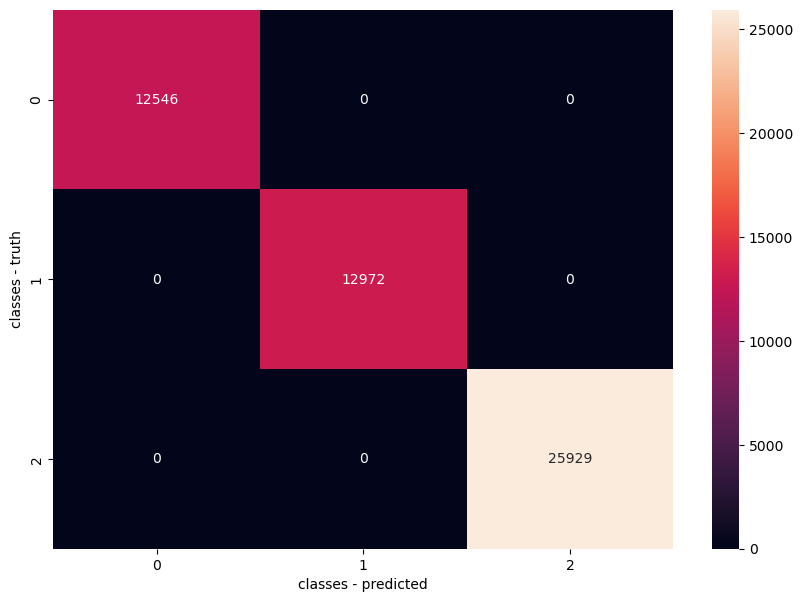

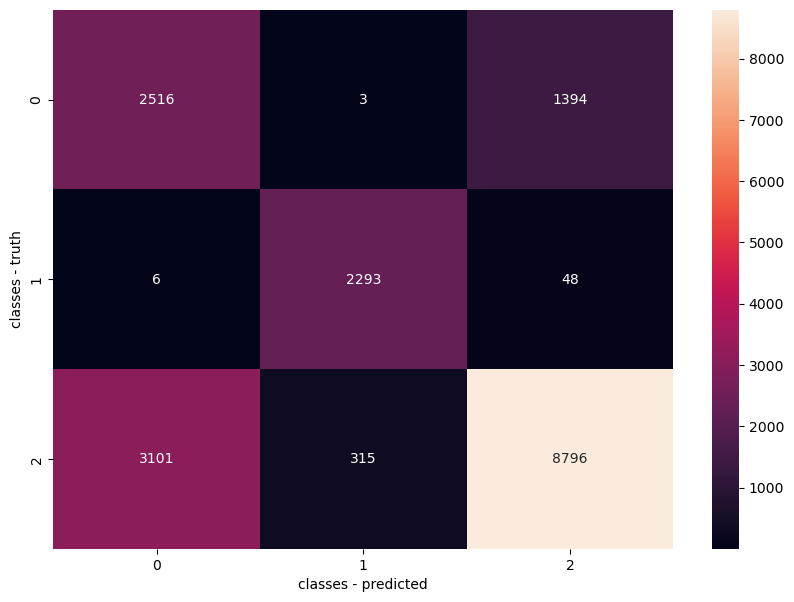

In [7]:

#===========================Main Classification Loop===========================#
train_tile_path = os.path.join(in_dir, f'stacked_bands_tile_input_{train_val_grid_id}.tif') # grid-clipped-image containing the training data
results_txt = os.path.join(output_folder, 'Results_Summary.txt') # directory, where the all meta results will be saved
TCRF.print_header(results_txt, DEM_path, ortho_path, train_tile_path, training_path, validation_path, img_path_list, attribute) # print the header for the results text file
train_tile, train_tile_3Darray = TCRF.extract_image_data(train_tile_path, results_txt, est, log=True) # extract the training tile image data
# Extract training data from shapefile
X_train, y_train, labels, roi = TCRF.extract_shapefile_data(training_path, train_tile, train_tile_3Darray, results_txt, attribute, "TRAINING")
rf, rf2 = TCRF.train_RF(X_train, y_train, train_tile, results_txt, est, n_cores, verbose) # train the random forest classifier
train_tile_2Darray = TCRF.flatten_raster_bands(train_tile_3Darray) # Convert NaNs to 0.0
class_prediction = TCRF.predict_classification(rf, train_tile_2Darray, train_tile_3Darray) # predict the classification for each pixel using the trained model
masked_prediction = TCRF.reshape_and_mask_prediction(class_prediction, train_tile_3Darray) # mask the prediction to only include bare earth and vegetation
TCRF.save_classification_image(classification_image, train_tile, train_tile_3Darray, masked_prediction) # save the masked classification image
# Extract validation data from shapefile
X_v, y_v, labels_v, roi_v = TCRF.extract_shapefile_data(validation_path, train_tile, class_prediction, results_txt, attribute, "VALIDATION") 
TCRF.model_evaluation(X_v, y_v, labels_v, roi_v, class_prediction, results_txt) # evaluate the model using the validation data

del train_tile # close the image dataset